## Reading Data


In [2]:
import pandas as pd
import numpy as np
import gc
import time
import warnings

#stats
#from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns

#import matplotlib_venn as venn


In [3]:
#nlp (Natural Language Processing)
import string
import re    #for regex
import nltk
#nltk.download('stopwords')
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
#Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer 

In [4]:
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

#settings
start_time= time.time()
color = sns.color_palette()
sns.set_style("dark")
#eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")
lem = WordNetLemmatizer()
tokenizer= TweetTokenizer()

%matplotlib inline

In [5]:
from PIL import Image

In [6]:
#importing the dataset
train=pd.read_csv("../data/train.csv")
#test=pd.read_csv("test.csv")

In [7]:
#take a peak
temporary=train
train.tail()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


Marking comments without any tags as "clean"

In [8]:
x=train.iloc[:,2:].sum()
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)

Count number of clean entries

In [9]:
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


Checking for the missing values in Train dataset

In [10]:
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
#print("Check for missing values in Test dataset")
#null_check=test.isnull().sum()
#print(null_check)
#print("filling NA with \"unknown\"")
train["comment_text"].fillna("unknown", inplace=True)
#test["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64


Bar Charts : Showcasing the categories of toxic comments

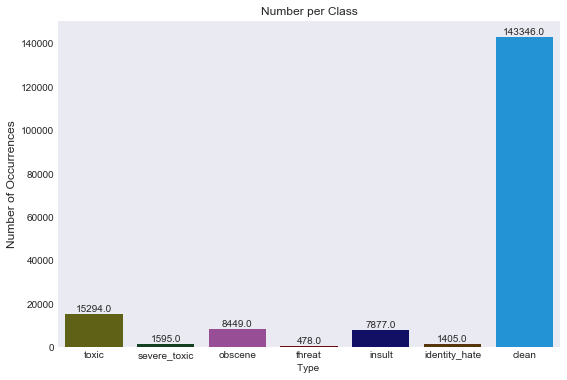

In [11]:
"""x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()
"""
colors_list = ["brownish green", "pine green", "ugly purple",
               "blood", "deep blue", "brown", "azure"]

palette= sns.xkcd_palette(colors_list)

x=train.iloc[:,2:].sum()

plt.figure(figsize=(9,6))
ax= sns.barplot(x.index, x.values,palette=palette)
plt.title("Number per Class")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Type ')
rects = ax.patches

labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, 
            ha='center', va='bottom')

plt.show()

Quick check for empty comments

In [12]:
empty_comments=train[train.comment_text==""]
empty_comments.sum()

id               0.0
comment_text     0.0
toxic            0.0
severe_toxic     0.0
obscene          0.0
threat           0.0
insult           0.0
identity_hate    0.0
clean            0.0
dtype: float64

A quick check for duplicated comments

In [13]:
duplicate=train.comment_text.duplicated()
duplicate[duplicate==True].sum()

0

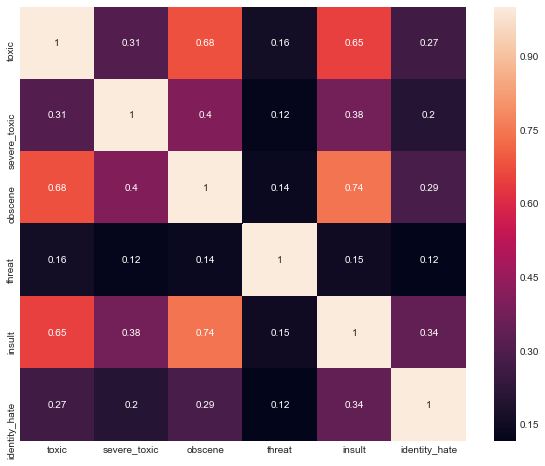

In [14]:
temp_df=train.iloc[:,2:-1]
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

Confusion Matrix

In [15]:
#https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix/39266194
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [16]:
#Checking for Toxic and Severe toxic for now
import pandas as pd
col1="toxic"
col2="severe_toxic"
confusion_matrix = pd.crosstab(temp_df[col1], temp_df[col2])
print("Confusion matrix between toxic and severe toxic:")
print(confusion_matrix)
new_corr=cramers_corrected_stat(confusion_matrix)
print("The correlation between Toxic and Severe toxic using Cramer's stat=",new_corr)

Confusion matrix between toxic and severe toxic:
severe_toxic       0     1
toxic                     
0             144277     0
1              13699  1595
The correlation between Toxic and Severe toxic using Cramer's stat= 0.30850290540548614


Quick view of toxic comments.

In [17]:
#We can use the same for Toxic, Severe Toxic etc.,
print("toxic:")
print(train[train.toxic==1].iloc[6,1])
#print(train[train.severe_toxic==1].iloc[5,1])

toxic:
GET FUCKED UP. GET FUCKEEED UP.  GOT A DRINK THAT YOU CANT PUT DOWN???/ GET FUCK UP GET FUCKED UP.  I'M FUCKED UP RIGHT NOW!


## Frequent words from dataset

We will plot wordclouds. The detail on how the cloud was created is from https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial

Exploring clean data from WordCloud Patterns

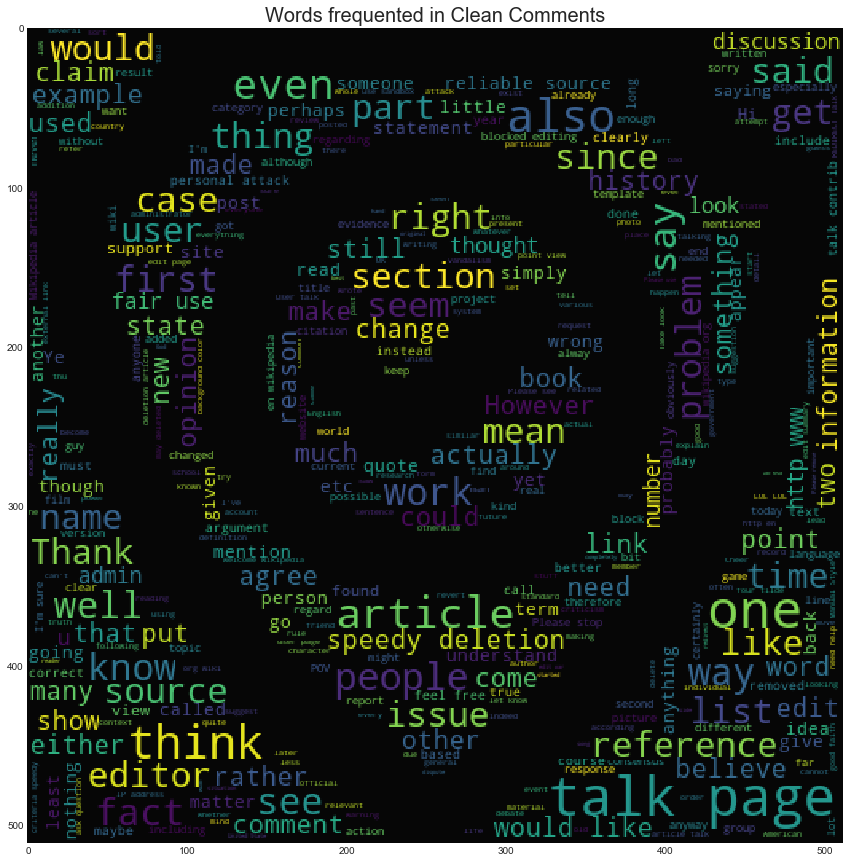

In [33]:
#clean comments
clean_mask=np.array(Image.open("../data/images/safe.png"))
clean_mask=clean_mask[:,:,1]
stopword=eng_stopwords
#wordcloud for clean comments
subset=train[train.clean==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=1000,mask=clean_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(25,15))
plt.axis("on")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

Exploring the toxic data from WordCloud Patterns

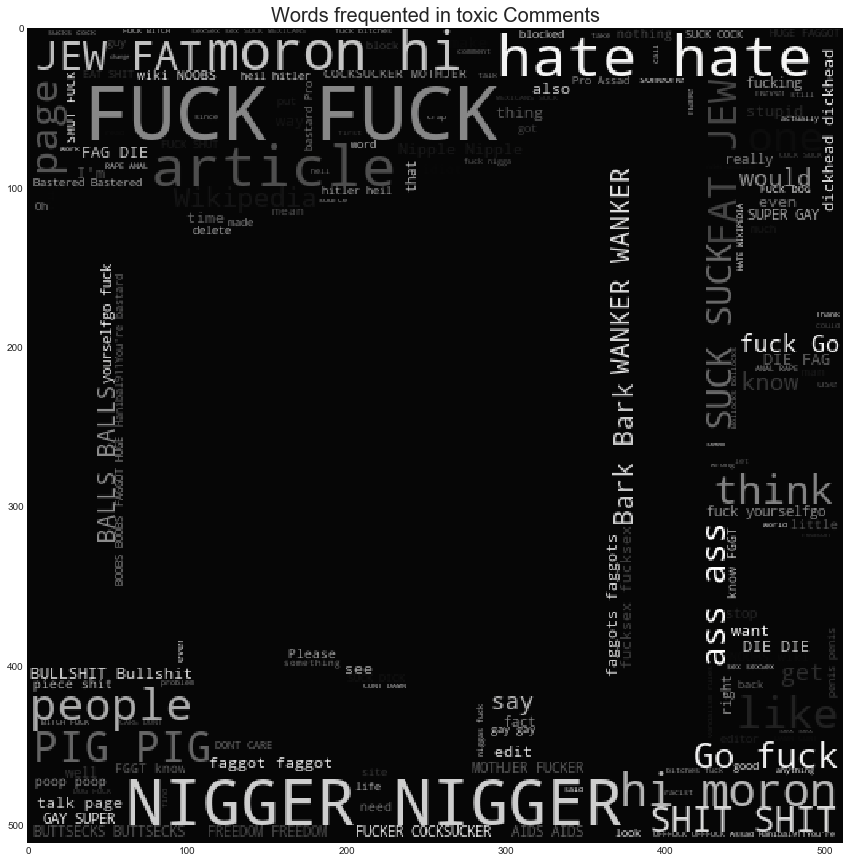

In [24]:
#toxic comments
clean_mask=np.array(Image.open("../data/images/megaphone.png"))
clean_mask=clean_mask[:,:,1]
stopword=eng_stopwords
#wordcloud for toxic comments
subset=train[train.toxic==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=1000,mask=clean_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(25,15))
plt.axis("on")
plt.title("Words frequented in toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gray' , random_state=17), alpha=0.98)
plt.show()

Exploring Severe severe toxic data from WordCloud Patterns

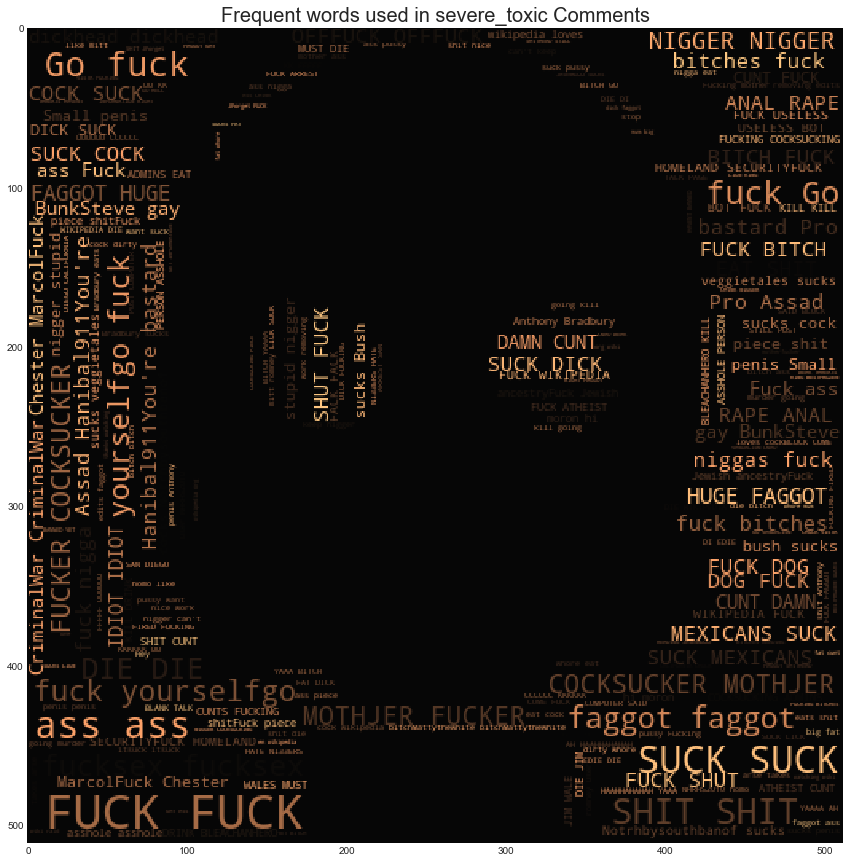

In [27]:
#severe_toxic comments
severe_toxic_mask=np.array(Image.open("../data/images/mask.png"))
severe_toxic_mask=severe_toxic_mask[:,:,1]
stopword=eng_stopwords
#wordcloud for severe_toxic comments
subset=train[train.severe_toxic==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=10000,mask=severe_toxic_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(25,15))
plt.axis("on")
plt.title("Frequent words used in severe_toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'copper' , random_state=17), alpha=0.98)
plt.show()

Exploring Obscene data from WordCloud Patterns

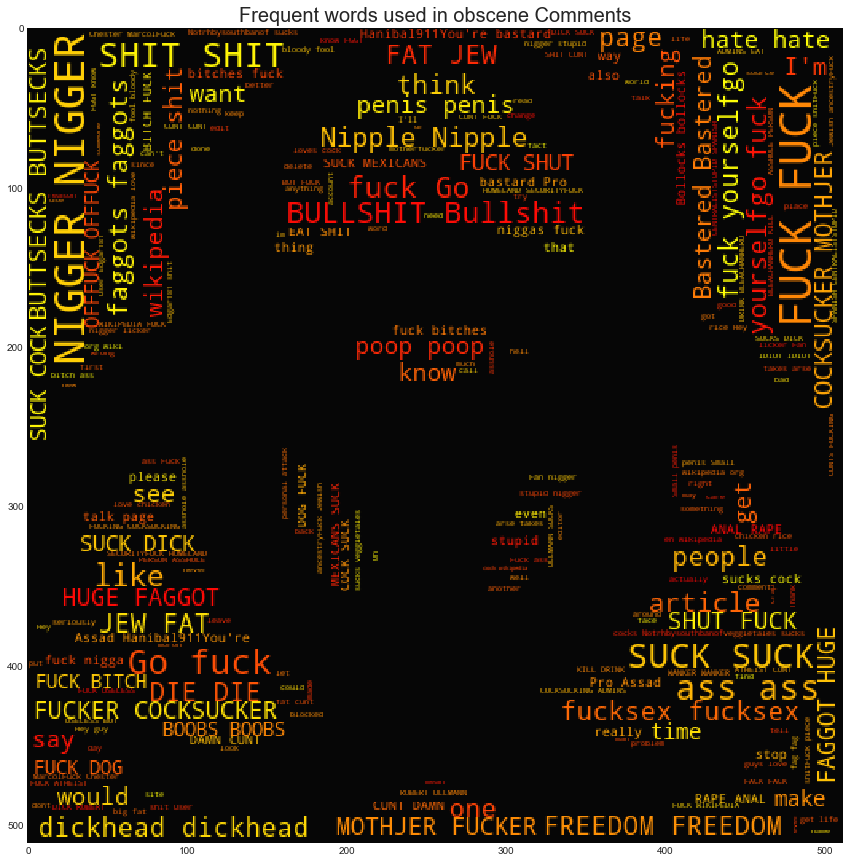

In [42]:
#obscene comments
insult_mask=np.array(Image.open("../data/images/biohazard.png"))
insult_mask=insult_mask[:,:,1]
stopword=eng_stopwords
#wordcloud for obscene comments
subset=train[train.obscene==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=1000,mask=insult_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(25,15))
plt.axis("on")
plt.title("Frequent words used in obscene Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'autumn' , random_state=17), alpha=0.98)
plt.show()

Exploring Insult data from WordCloud Patterns

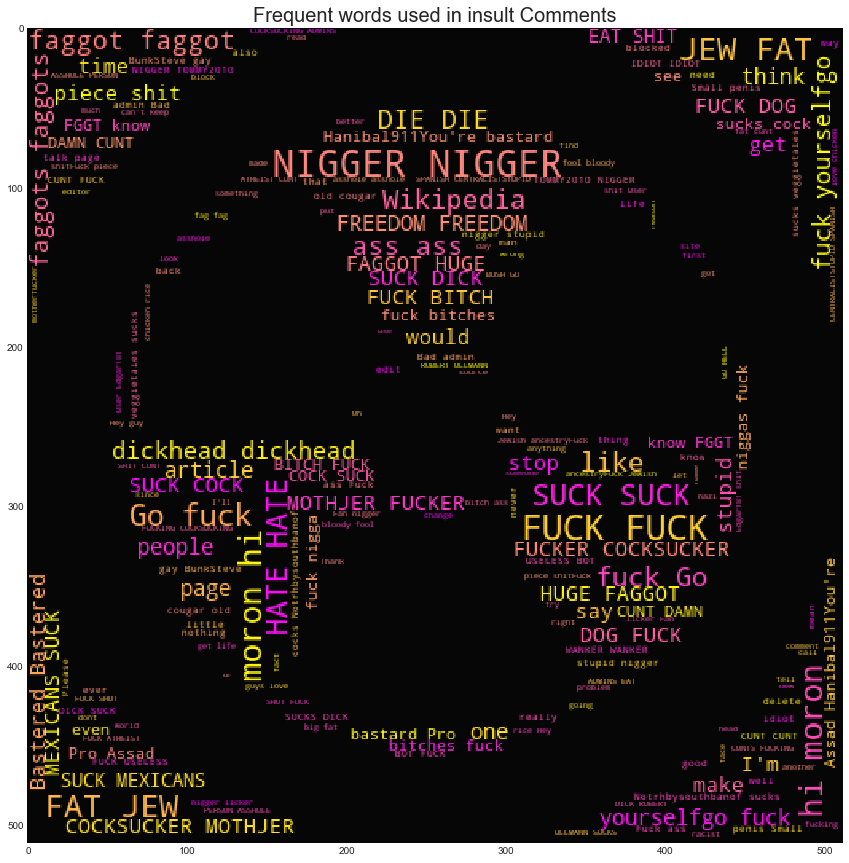

In [43]:
#insult comments
insult_mask=np.array(Image.open("../data/images/toxic-sign.png"))
insult_mask=insult_mask[:,:,1]
stopword=eng_stopwords
#wordcloud for insult comments
subset=train[train.insult==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=1000,mask=insult_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(25,15))
plt.axis("on")
plt.title("Frequent words used in insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'spring' , random_state=17), alpha=0.98)
plt.show()

Exploring the threat data from WordCloud Patterns

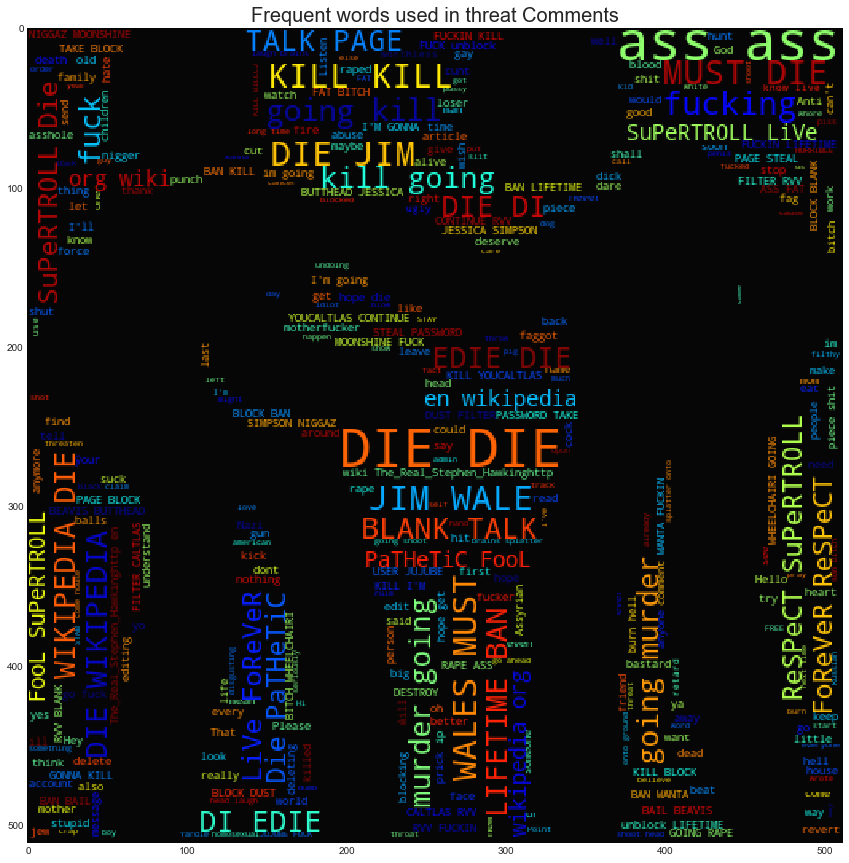

In [37]:
#threat comments
threat_mask=np.array(Image.open("../data/images/anger.png"))
threat_mask=threat_mask[:,:,1]
stopword=eng_stopwords
#wordcloud for threat comments
subset=train[train.threat==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=10000,mask=threat_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(25,15))
plt.axis("on")
plt.title("Frequent words used in threat Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'jet' , random_state=17), alpha=0.98)
plt.show()

Exploring identity_hate data from WordCloud Patterns

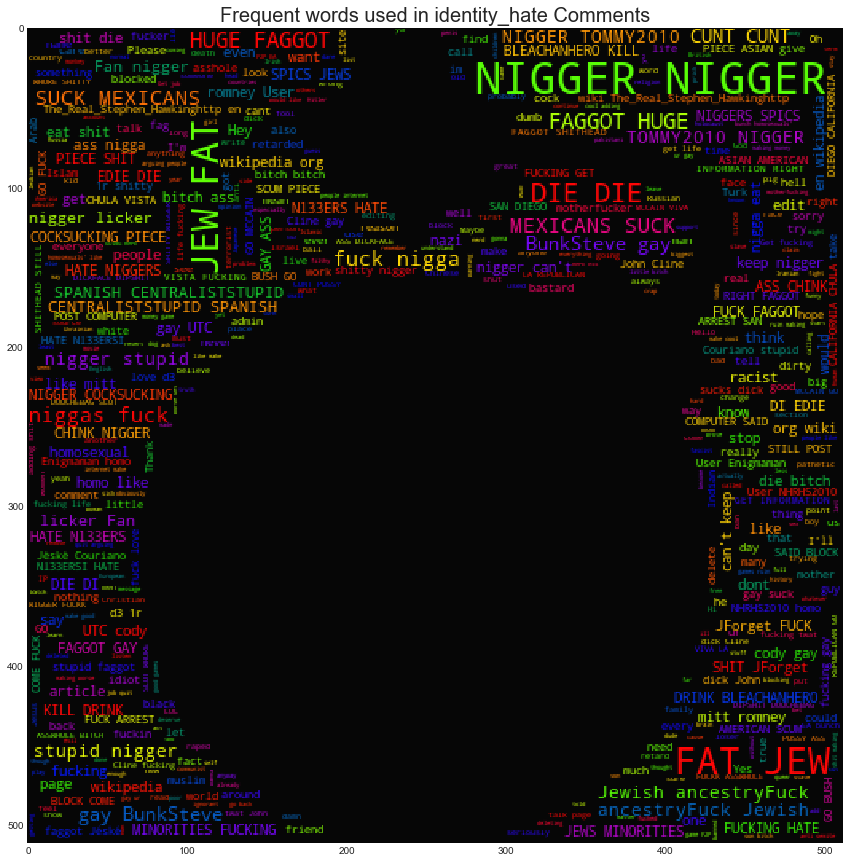

In [38]:
#identity_hate comments
identity_hate_mask=np.array(Image.open("../data/images/bomb.png"))
identity_hate_mask=identity_hate_mask[:,:,1]
stopword=eng_stopwords
#wordcloud for identity_hate comments
subset=train[train.identity_hate==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=1000,mask=identity_hate_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(25,15))
plt.axis("on")
plt.title("Frequent words used in identity_hate Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'prism' , random_state=17), alpha=0.98)
plt.show()

In [45]:
import sys
sys.executable

'/anaconda3/bin/python'

## Analysis

In [18]:
##########################################################################

## Looking at the data



In [46]:
train.head()

#traincopy=train


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,True
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,True
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,True
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,True
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,True


In [47]:
train=train[ (train.toxic!=0) | (train.severe_toxic!=0) | (train.obscene!=0) | (train.threat!=0) | (train.insult!=0) | (train.identity_hate!=0) ] 
print(train.shape)

(16225, 9)


In [48]:
train_clean=temporary[temporary.clean!=False].sample(n=3000,random_state=112) 
print(train_clean.shape)


(3000, 9)


Here's a couple of examples of comments, one toxic, and one with no labels.

In [49]:
train_clean.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
2659,0723fe0415703261,Inappropriate edit summaries \n\nThis edit sum...,0,0,0,0,0,0,True
71265,bec25baa4044976a,Ignatieff talk page\nYour comments were most h...,0,0,0,0,0,0,True
18987,32214e8cb761daf8,"""\n\n (//c) lightly smacks Wafulz with a minno...",0,0,0,0,0,0,True
85124,e3c0b9077a97dec8,"Or, we could just deleted it as an unreference...",0,0,0,0,0,0,True
76736,cd81141bde872b82,"January 2012 (UTC)\nAll done. 20:16, 13",0,0,0,0,0,0,True


In [23]:
train['comment_text'][12]

'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...'

In [24]:
train['comment_text'][6]

'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'

The length of the comments varies a lot.
We have also considered spaces.

In [50]:
lens = train.comment_text.str.len()
#print(lens)
lens.mean(), lens.std(), lens.max()
max_text=lens.max()
#print(max(train['comment_text']).value())
#def Words(): qfile=open('dict.txt','r') longg='' for line in qfile: if len(line)>len(longg): longg=line return longg


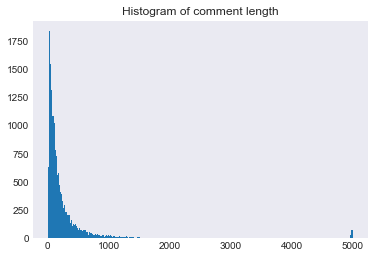

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(lens.values, bins="auto") 
plt.title("Histogram of comment length")
plt.show()

We'll create a list of all the labels to predict, and we'll also create a 'none' label so we can see how many comments have no labels. We can then summarize the dataset.

#### Now lets analyse statistics of the overall dataset

In [51]:
#Not sure what this is
print(len(train),len(train_clean))
#temporary=train

16225 3000


There are a few empty comments that we need to get rid of, otherwise sklearn will complain.

## Analysis

## Feature Selection/ Feature Engg

multiple simple features and some complex features as shown below

#### Simple features
* count of sentences 
* count of words
* count of unique words
* count of letters 
* count of punctuations
* count of uppercase words/letters
* count of stop words
* Avg length of each word


#### Complex features
* TFIDF
* Word2vec
* Glove


*In the next two cells I am creating a table of simple features for each text

In [52]:
merge=pd.concat([train.iloc[:,0:2],train_clean.iloc[:,0:2]])
mergelabels=pd.concat([train.iloc[:,2:],train_clean.iloc[:,2:]])
#please see what iloc does
df=merge.reset_index(drop=True)
train_tags=mergelabels.iloc[:,:]
#You have to reset index thats y the error was coming
train_tags=train_tags.reset_index(drop=True)
train_tags

,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,1,1,1,0,1,0,False
1,1,0,0,0,0,0,False
2,1,0,0,0,0,0,False
3,1,0,1,0,1,1,False
4,1,0,1,0,1,0,False
5,1,0,0,0,0,0,False
6,1,0,1,0,0,0,False
7,1,1,1,0,1,0,False
8,1,0,1,0,1,0,False
9,1,0,1,0,0,0,False


## Final Dataset 

In [ ]:
df

In [53]:
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [54]:
df.to_csv("ml_dataset.csv")
df.head()

,id,comment_text,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len
0,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,8,8,44,0,8,0,4,4.625000
1,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,5,53,50,319,24,6,4,22,5.018868
2,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",3,10,10,57,5,0,2,3,4.600000
3,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,15,117,88,648,28,3,16,53,4.478632
4,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,8,8,40,2,8,0,3,4.125000


In [ ]:
## You are not considering the tags

In [ ]:
## error was below
#train_tags=df.iloc[:,1:]# getting class labels
#train_tags=pd.concat([train.iloc[:,2:8]])
#train_tags


In [55]:
train_feats=df
train_feats.shape

(19225, 11)

### Cleaning corpus

Clean before generating count vectors

In [56]:
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not"
}

def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    #Convert to lower case , so that Hi and hi are the same
    comment=comment.lower()
    #remove \n
    comment=re.sub("\\n","",comment)
    # remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)
    
    #Split the sentences into words
    words=tokenizer.tokenize(comment)
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words=[APPO[word] if word in APPO else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    clean_sent=" ".join(words)
    # remove any non alphanum,digit character
    #clean_sent=re.sub("\W+"," ",clean_sent)
    #clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)


In [57]:
corpus=df.comment_text
corpus.iloc[11285]


'do NOT get yourself killed, child \n\nyou do not want to get yourself killed tampering with information on this topic, child.'

In [58]:
#clean(corpus.iloc[12235])
clean_corpus=corpus.apply(lambda x :clean(x)) 
end_time=time.time()
print("total time till Cleaning",end_time-start_time)
print(clean_corpus)
clean_corpus.shape


total time till Cleaning 3496.7243070602417
0                              cocksucker piss around work
1        hey ... .. @ | talk . ... exclusive group wp t...
2        bye ! do not look , come think comming back ! ...
3        gay antisemmitian ? archangel white tigermeow ...
4                           fuck filthy mother ass , dry !
5        I am sorry I am sorry screw around someones ta...
6        get fuck . get fuckeeed . get drink cant put ?...
7        stupid peace shit stop delete stuff asshole go...
8        = tony sidaway obviously fistfuckee . love arm...
9        band page's deletion . think go . delete comme...
10       cannot believe fat artie ? see recent appearen...
11       edit good . cunts like revert good edit you ar...
12            hi ! back ! last warn ! stop undo edit die !
13       would shut , do not run wikipedia , especially...
14                  pair jew-hating weiner nazi schmucks .
15       " sorry puck one ever say dick number one ! ! ...
16       " u

(19225,)

### Complex features

Lets create some features based on frequency distribution of the words. Initially lets consider taking words one at a time (ie) Unigrams

Python's SKlearn provides 3 ways of creating count features.All three of them first create a vocabulary(dictionary) of words and then create a [sparse matrix](#https://en.wikipedia.org/wiki/Sparse_matrix) of word counts for the words in the sentence that are present in the dictionary. A brief description of them:
* CountVectorizer
    * Creates a matrix with frequency counts of each word in the text corpus
* TF-IDF Vectorizer
    * TF - Term Frequency -- Count of the words(Terms) in the text corpus (same of Count Vect)
    * IDF - Inverse Document Frequency -- Penalizes words that are too frequent. We can think of this as regularization
* HashingVectorizer
    * Creates a hashmap(word to number mapping based on hashing technique) instead of a dictionary for vocabulary
    * This enables it to be more scalable and faster for larger text coprus
    * Can be parallelized across multiple threads
        
Using TF-IDF here.
Note: Using the concatenated dataframe "merge" which contains both text from train and test dataset to ensure that the vocabulary that we create does not missout on the words that are unique to testset.

In [59]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    
    D = Xtr[grp_ids].toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

# modified for multilabel milticlass
def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    cols=train_tags.columns
    print(train_tags.shape)
    for col in cols:
        ids = train_tags.index[train_tags[col]==1]
        print("ids are ")
        print(ids)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split


### Unigrams -- TF-IDF 
# using settings recommended here for TF-IDF -- https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle

start_unigrams=time.time()
tfv = TfidfVectorizer(min_df=200,  max_features=10000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())

train_unigrams =  tfv.transform(clean_corpus)
tfidf_top_n_per_class_uni=top_feats_by_class(train_bigrams,features)
print(len(features))
print(clean_corpus)

(19225, 7)
ids are 
Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            16215, 16216, 16217, 16218, 16219, 16220, 16221, 16222, 16223,
            16224],
           dtype='int64', length=15294)
ids are 
Int64Index([    0,     7,    20,    46,    56,    82,    83,    84,    96,
              111,
            ...
            16131, 16132, 16145, 16160, 16164, 16181, 16182, 16197, 16201,
            16213],
           dtype='int64', length=1595)
ids are 
Int64Index([    0,     3,     4,     6,     7,     8,     9,    11,    14,
               18,
            ...
            16205, 16207, 16208, 16209, 16213, 16214, 16219, 16220, 16222,
            16224],
           dtype='int64', length=8449)
ids are 
Int64Index([   12,    18,    59,    85,   111,   116,   137,   154,   200,
              212,
            ...
            15955, 16000, 16009, 16032, 16039, 16042, 16152, 16160, 16172,
            16213],
           dtyp

In [66]:

start_time=time.time()
tfv = TfidfVectorizer(min_df=100,max_features=10000, 
            strip_accents='unicode', analyzer='char',ngram_range=(4,4),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(clean_corpus)
features_four = np.array(tfv.get_feature_names())
train_charngrams =  tfv.transform(clean_corpus)
end_time=time.time()
print("total time till charngrams",end_time-start_time)

total time till charngrams 5.842711925506592


In [63]:
tfv = TfidfVectorizer(min_df=50,  max_features=10000, 
               strip_accents='unicode', analyzer='word',ngram_range=(2,2),
               use_idf=1,smooth_idf=1,sublinear_tf=1,
               stop_words = 'english') 
tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())
print(features)
train_bigrams =  tfv.transform(clean_corpus)
#get top n for bigrams
print(train_bigrams.shape)
tfidf_top_n_per_lass=top_feats_by_class(train_bigrams,features)
print(len(features))

['2005 utc' 'act like' 'article wikipedia' 'block edit' 'comment add'
 'delete article' 'delete page' 'discussion page' 'does mean' 'dont know'
 'eat shit' 'edit article' 'edit make' 'edit page' 'edit summary'
 'edit war' 'edit wikipedia' 'en wikipedia' 'feel free' 'feel like'
 'fuck asshole' 'fuck bitch' 'fuck cunt' 'fuck faggot' 'fuck fuck'
 'fuck idiot' 'fuck retard' 'fuck shit' 'fuck stupid' 'fuck wikipedia'
 'god damn' 'good faith' 'ha ha' 'high school' 'http en' 'http www'
 'ip address' 'know fuck' 'let know' 'like fuck' 'like say' 'look like'
 'make edit' 'make look' 'make sense' 'make sure' 'mother fucker'
 'org wiki' 'page edit' 'page fuck' 'people like' 'personal attack'
 'piece shit' 'point view' 'precede unsigned' 'real life'
 'reliable source' 'revert edit' 'say fuck' 'shit fuck' 'shut fuck'
 'sock puppet' 'son bitch' 'sound like' 'spend time' 'stop edit'
 'suck cock' 'suck dick' 'talk contribs' 'talk page' 'think know'
 'try make' 'unsigned comment' 'use wikipedia' 'use w

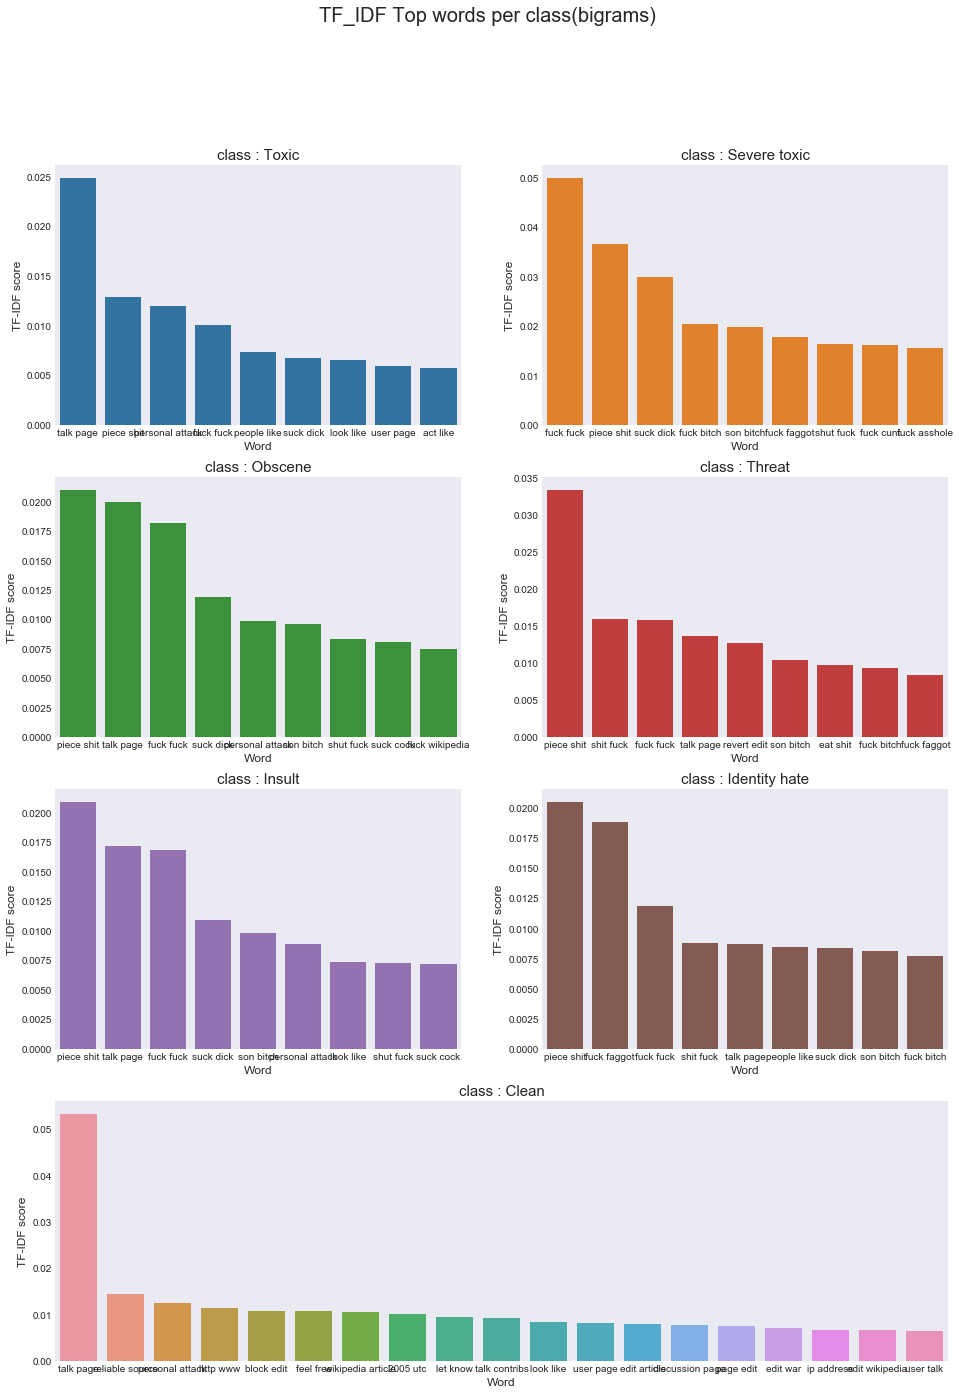

In [67]:
#tfidf_top_n_per_lass=top_feats_by_class(train_bigrams,features)
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(bigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:9],tfidf_top_n_per_lass[0].tfidf.iloc[0:9],color=color[0])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:9],tfidf_top_n_per_lass[1].tfidf.iloc[0:9],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:9],tfidf_top_n_per_lass[2].tfidf.iloc[0:9],color=color[2])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:9],tfidf_top_n_per_lass[3].tfidf.iloc[0:9],color=color[3])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:9],tfidf_top_n_per_lass[4].tfidf.iloc[0:9],color=color[4])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:9],tfidf_top_n_per_lass[5].tfidf.iloc[0:9],color=color[5])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:19],tfidf_top_n_per_lass[6].tfidf.iloc[0:19])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()

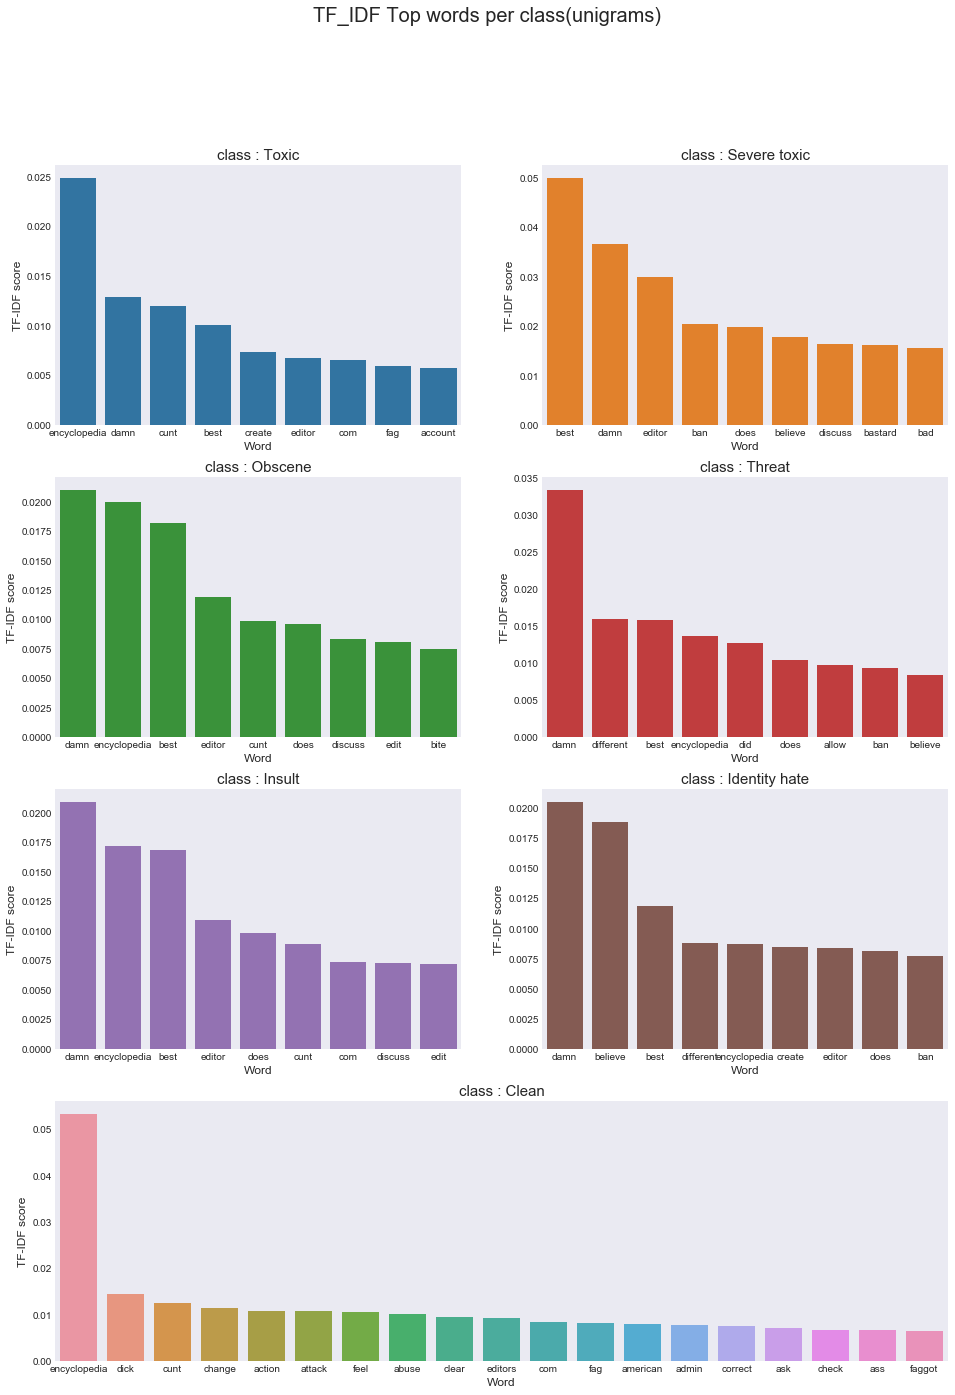

In [68]:
#tfidf_top_n_per_lass=top_feats_by_class(train_bigrams,features)
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(unigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_class_uni[0].feature.iloc[0:9],tfidf_top_n_per_class_uni[0].tfidf.iloc[0:9],color=color[0])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_class_uni[1].feature.iloc[0:9],tfidf_top_n_per_class_uni[1].tfidf.iloc[0:9],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_class_uni[2].feature.iloc[0:9],tfidf_top_n_per_class_uni[2].tfidf.iloc[0:9],color=color[2])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_class_uni[3].feature.iloc[0:9],tfidf_top_n_per_class_uni[3].tfidf.iloc[0:9],color=color[3])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_class_uni[4].feature.iloc[0:9],tfidf_top_n_per_class_uni[4].tfidf.iloc[0:9],color=color[4])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_class_uni[5].feature.iloc[0:9],tfidf_top_n_per_class_uni[5].tfidf.iloc[0:9],color=color[5])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_class_uni[6].feature.iloc[0:19],tfidf_top_n_per_class_uni[6].tfidf.iloc[0:19])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()

## Word Embedding Features

In [43]:
with open("../data/glove.6B.50d.txt", "rb") as lines:
    w2v = {line.split()[0]: np.array(map(float, line.split()[1:]))
           for line in lines}
import gensim
# # # let X be a list of tokenized texts (i.e. list of lists of tokens)
# from gensim.models import word2vec
# tokentext=[i.split() for i in clean_corpus]
# model = word2vec.Word2Vec(tokentext, size=100, window=5, min_count=5, workers=4)
# w2v = dict(zip(model.wv.index2word, model.wv.syn0))


# start_time=time.time()
# clean_corpus=corpus.apply(lambda x :clean(x))

# end_time=time.time()
# print("total time till Cleaning",end_time-start_time)


class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.itervalues().next())

    def fit(self, X):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(next(iter(word2vec)))

    def fit(self, X):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [44]:
from collections import defaultdict
wordvect = TfidfEmbeddingVectorizer(w2v)
wordvect.fit(clean_corpus)
wordvectors =  wordvect.transform(clean_corpus.iloc[:merge.shape[0]])

## Model Building

In [45]:
train_feats

,id,comment_text,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len
0,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,8,8,44,0,8,0,4,4.625000
1,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,5,53,50,319,24,6,4,22,5.018868
2,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",3,10,10,57,5,0,2,3,4.600000
3,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,15,117,88,648,28,3,16,53,4.478632
4,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,8,8,40,2,8,0,3,4.125000
5,001956c382006abd,I'm Sorry \n\nI'm sorry I screwed around with ...,3,56,45,319,16,4,7,25,4.571429
6,001dc38a83d420cf,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,25,17,124,9,25,2,5,3.920000
7,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,19,18,89,1,0,1,6,3.736842
8,0020fd96ed3b8c8b,=Tony Sidaway is obviously a fistfuckee. He lo...,1,13,13,68,3,0,3,6,4.307692
9,0021fe88bc4da3e6,My Band Page's deletion. You thought I was gon...,8,322,228,1798,80,6,42,139,4.574534


In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


SELECTED_COLS=['count_sent', 'count_word', 'count_unique_word',
       'count_letters', 'count_punctuations', 'count_words_upper',
       'count_words_title', 'count_stopwords']

target_x=train_feats[SELECTED_COLS]
# target_x
target1 = mergelabels
TARGET_COLS=['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate',"clean"]
train_tags.head
target_y=target1[TARGET_COLS]
print(target_x.shape,target_y.shape)

(19225, 8) (19225, 7)


In [47]:
from scipy.sparse import csr_matrix, hstack


import pickle as pickle
#Using all direct features
print("Using all features")

aa=[[i] for i in range(0, 19225)]
aa=np.array(aa)
aa=csr_matrix(aa)
print(type(aa))
print(aa.shape)
print((train_unigrams.shape))
target_x1=hstack((aa,train_unigrams)).tocsr()
target_x2=hstack((aa,train_bigrams)).tocsr()#train_bigrams
target_x3=hstack((aa,train_charngrams)).tocsr()#train_charngrams
target_x4=hstack((aa,train_feats[SELECTED_COLS])).tocsr()#train_feats[SELECTED_COLS]
target_x5= wordvectors
target_x6 = hstack((aa,train_bigrams,train_charngrams,train_unigrams,train_feats[SELECTED_COLS])).tocsr()
target_x7 = hstack((aa,train_bigrams,train_unigrams)).tocsr()
target_x8 = hstack((aa,train_unigrams, train_charngrams)).tocsr()
target_x9 = hstack((aa,train_unigrams, train_charngrams,train_bigrams)).tocsr()


with open("target_x1_mlnew.pkl", 'wb') as handle:
                    pickle.dump(target_x1, handle)

with open("target_x2_mlnew.pkl", 'wb') as handle:
                    pickle.dump(target_x2, handle)

with open("target_x3_mlnew.pkl", 'wb') as handle:
                    pickle.dump(target_x3, handle)
with open("target_x4_mlnew.pkl", 'wb') as handle:
                    pickle.dump(target_x4, handle)

with open("target_x5_mlnew.pkl", 'wb') as handle:
                    pickle.dump(target_x5, handle)
with open("target_x6_mlnew.pkl", 'wb') as handle:
                    pickle.dump(target_x6, handle)
with open("target_x7_mlnew.pkl", 'wb') as handle:
                    pickle.dump(target_x7, handle)
with open("target_x8_mlnew.pkl", 'wb') as handle:
                    pickle.dump(target_x8, handle)
with open("target_x9_mlnew.pkl", 'wb') as handle:
                    pickle.dump(target_x8, handle)
with open("target_yml.pkl", 'wb') as handle:
                    pickle.dump(target_y, handle)


print("Completed")

Using all features
<class 'scipy.sparse.csr.csr_matrix'>
(19225, 1)
(19225, 260)
Completed


## THE CODE FOR DATA CREATION END HERE